In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
help(keras.applications)
print(keras.__version__)
from keras import backend as K 

Help on package keras.applications in keras:

NAME
    keras.applications

PACKAGE CONTENTS
    densenet
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    nasnet
    resnet
    resnet50
    resnet_v2
    vgg16
    vgg19
    xception

FILE
    /usr/local/lib/python3.6/dist-packages/keras/applications/__init__.py


2.4.3


In [2]:
'''folder_benign_train = '/content/drive/My Drive/Melanoma_project/train/benign'
folder_malignant_train = '/content/drive/My Drive/Melanoma_project/train/malignant'

folder_benign_test = '/content/drive/My Drive/Melanoma_project/test/benign'
folder_malignant_test = '/content/drive/My Drive/Melanoma_project/test/malignant'
'''

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [3]:
from google.colab import drive
from pathlib import Path

# ref : https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

zip_path = '/content/drive/My Drive/Melanoma_project/image_folder.zip'
!cp "{zip_path}" .
!unzip -q image_folder.zip
!rm image_folder.zip  # to copy the zip from drive to colab and then get the data - makes the loading process much faster

In [4]:
# Load in training pictures 
import os
ims_benign = [read(os.path.join('/content/train/benign', filename)) for filename in os.listdir('/content/train/benign')]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/train/malignant', filename)) for filename in os.listdir('/content/train/malignant')]
X_malignant = np.array(ims_malignant, dtype='uint8')


In [5]:
# Load in testing pictures

ims_benign = [read(os.path.join('/content/test/benign', filename)) for filename in os.listdir('/content/test/benign')]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/test/malignant', filename)) for filename in os.listdir('/content/test/malignant')]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


In [6]:
# Create labels

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [7]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [8]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

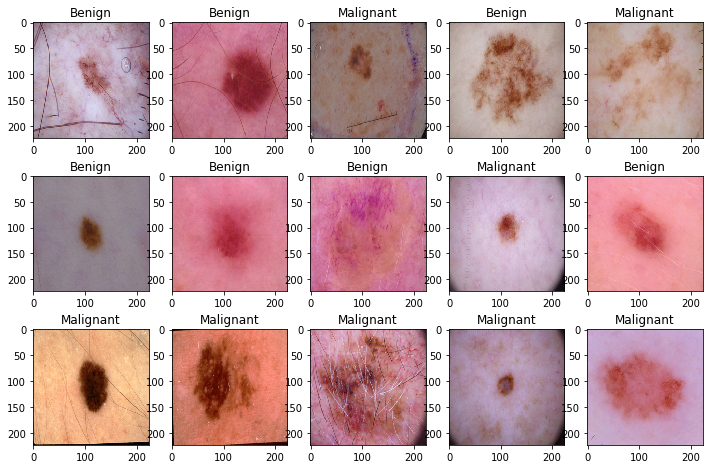

In [9]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## **Step 3: Categorical Labels**

In [10]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

## **Step 4 : Normalization**

In [11]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

# **Trying out ResNet152V2**

In [12]:
#Declaring stuff :
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

Epoch 1/50
33/33 - 53s - loss: 0.6125 - accuracy: 0.6690 - val_loss: 0.6963 - val_accuracy: 0.4640
Epoch 2/50
33/33 - 51s - loss: 0.4874 - accuracy: 0.7677 - val_loss: 0.6892 - val_accuracy: 0.5360
Epoch 3/50
33/33 - 50s - loss: 0.4306 - accuracy: 0.7956 - val_loss: 0.6981 - val_accuracy: 0.5360
Epoch 4/50
33/33 - 50s - loss: 0.4096 - accuracy: 0.7956 - val_loss: 0.7619 - val_accuracy: 0.5360
Epoch 5/50
33/33 - 50s - loss: 0.3859 - accuracy: 0.8080 - val_loss: 0.8401 - val_accuracy: 0.5360
Epoch 6/50
33/33 - 50s - loss: 0.3767 - accuracy: 0.8222 - val_loss: 0.8082 - val_accuracy: 0.5360
Epoch 7/50

Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
33/33 - 50s - loss: 0.3761 - accuracy: 0.8208 - val_loss: 0.8150 - val_accuracy: 0.5360
Epoch 8/50
33/33 - 50s - loss: 0.3582 - accuracy: 0.8326 - val_loss: 0.8403 - val_accuracy: 0.5379
Epoch 9/50
33/33 - 50s - loss: 0.3518 - accuracy: 0.8388 - val_loss: 0.6981 - val_accuracy: 0.5663
Epoch 10/50
33/33 - 50s - lo

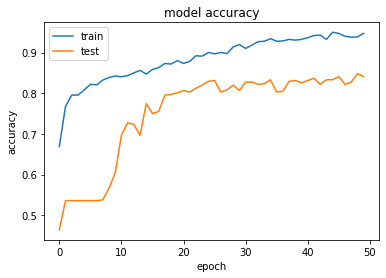

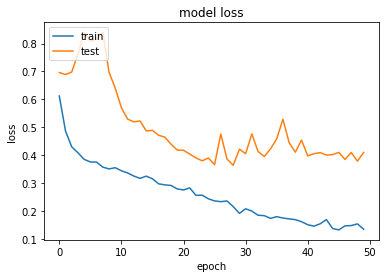

In [13]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet152V2(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# my comments :  

In [14]:
# Train ResNet152V2 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=2,
          callbacks=[learning_rate_reduction]
         )

Epoch 1/50
53/53 - 62s - loss: 0.2056 - accuracy: 0.9219
Epoch 2/50
53/53 - 60s - loss: 0.2094 - accuracy: 0.9181
Epoch 3/50
53/53 - 60s - loss: 0.2034 - accuracy: 0.9124
Epoch 4/50
53/53 - 60s - loss: 0.2044 - accuracy: 0.9170
Epoch 5/50
53/53 - 60s - loss: 0.2002 - accuracy: 0.9200
Epoch 6/50
53/53 - 60s - loss: 0.1937 - accuracy: 0.9181
Epoch 7/50
53/53 - 60s - loss: 0.1912 - accuracy: 0.9177
Epoch 8/50
53/53 - 60s - loss: 0.1985 - accuracy: 0.9139
Epoch 9/50
53/53 - 60s - loss: 0.1883 - accuracy: 0.9268
Epoch 10/50
53/53 - 60s - loss: 0.1887 - accuracy: 0.9215
Epoch 11/50
53/53 - 60s - loss: 0.1791 - accuracy: 0.9261
Epoch 12/50
53/53 - 60s - loss: 0.1748 - accuracy: 0.9295
Epoch 13/50
53/53 - 60s - loss: 0.1837 - accuracy: 0.9283
Epoch 14/50
53/53 - 60s - loss: 0.1759 - accuracy: 0.9279
Epoch 15/50
53/53 - 60s - loss: 0.1782 - accuracy: 0.9298
Epoch 16/50
53/53 - 60s - loss: 0.1836 - accuracy: 0.9298
Epoch 17/50
53/53 - 60s - loss: 0.1722 - accuracy: 0.9283
Epoch 18/50
53/53 - 60s

In [16]:
# save model
model.save('/content/drive/My Drive/Melanoma_project/resnet152_saved_model.h5')

# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

# Accuracy
print("accuracy score : ",accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# Precision
print("precision score : ",precision_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# Recall
print("recall score : ",recall_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# F1-score
print("f1 score : ",f1_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))
# F-beta-score
print("f beta score : ",fbeta_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1),beta=10))
# confusion matrix:
print("confusion matrix : ",confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1)))


'''
# serialize model to JSON
ResNet152V2_json = model.to_json()

with open("ResNet152V2.json", "w") as json_file:
    json_file.write(ResNet152V2_json)
    
# serialize weights to HDF5
model.save_weights("ResNet152V2.h5")
print("Saved model to disk")

# my comments : 
'''

0.8303030303030303
accuracy score :  0.8303030303030303
precision score :  0.8241379310344827
recall score :  0.7966666666666666
f1 score :  0.8101694915254237
f beta score :  0.7969296797622978
confusion matrix :  [[309  51]
 [ 61 239]]


'\n# serialize model to JSON\nResNet152V2_json = model.to_json()\n\nwith open("ResNet152V2.json", "w") as json_file:\n    json_file.write(ResNet152V2_json)\n    \n# serialize weights to HDF5\nmodel.save_weights("ResNet152V2.h5")\nprint("Saved model to disk")\n\n# my comments : \n'